In [1]:
# =================================================================================================
# KAGGLE NOTEBOOK: VEHICLE DETECTION & SCENE CLASSIFICATION IN ADVERSE WEATHER
# =================================================================================================

# --- [PHASE 0] IMPORTS AND SETUP ---
print("="*80)
print("--- [PHASE 0] IMPORTS AND SETUP ---")
print("="*80)
import os
import shutil
import random
import json
import yaml
import glob
from tqdm.notebook import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully.\n")

--- [PHASE 0] IMPORTS AND SETUP ---
Libraries imported successfully.



In [3]:
# --- [PHASE 1] CONFIGURATION AND CONSTANTS ---
print("="*80)
print("--- [PHASE 1] CONFIGURATION AND CONSTANTS ---")
print("="*80)
BDD_INPUT_PATH = "/kaggle/input/vehicle-dataset/Dataset/BDD10K/"
DAWN_INPUT_PATH = "/kaggle/input/vehicle-dataset/Dataset/DAWN/"
BASE_OUTPUT_PATH = "/kaggle/working/"
PREPARED_DATA_PATH = os.path.join(BASE_OUTPUT_PATH, "prepared_data")
SCENE_DATA_PATH = os.path.join(PREPARED_DATA_PATH, "scene_classifier_data")
SCENE_TRAIN_PATH = os.path.join(SCENE_DATA_PATH, "train")
SCENE_VAL_PATH = os.path.join(SCENE_DATA_PATH, "val")
SCENE_TEST_PATH = os.path.join(SCENE_DATA_PATH, "test")
YOLO_DATA_PATH = os.path.join(PREPARED_DATA_PATH, "yolo_detector_data")
YOLO_IMAGES_PATH = os.path.join(YOLO_DATA_PATH, "images")
YOLO_LABELS_PATH = os.path.join(YOLO_DATA_PATH, "labels")
FINAL_MODELS_PATH = os.path.join(BASE_OUTPUT_PATH, "final_trained_models")

MASTER_OBJECT_CLASSES = {
    'person': 0, 'rider': 0, 'car': 1, 'truck': 2, 'bus': 3,
    'bike': 4, 'motor': 5, 'traffic light': 6, 'traffic sign': 7,
}
YOLO_CLASS_NAMES = ['person', 'car', 'truck', 'bus', 'bicycle', 'motorcycle', 'traffic light', 'traffic sign']
POTENTIAL_SCENE_CLASSES = [
    'Clear-Day', 'Overcast-Day', 'Rainy', 'Snowy', 'Foggy',
    'Night', 'Dusk-Dawn', 'Sandstorm'
]

YOLO_EPOCHS = 50
YOLO_BATCH_SIZE = 16
RESNET_EPOCHS = 20
RESNET_BATCH_SIZE = 32
LEARNING_RATE = 0.001

print(f"YOLOv7 Object Classes: {YOLO_CLASS_NAMES}")
print(f"Potential Scene Classes: {POTENTIAL_SCENE_CLASSES}")
print("Configuration complete.\n")

--- [PHASE 1] CONFIGURATION AND CONSTANTS ---
YOLOv7 Object Classes: ['person', 'car', 'truck', 'bus', 'bicycle', 'motorcycle', 'traffic light', 'traffic sign']
Potential Scene Classes: ['Clear-Day', 'Overcast-Day', 'Rainy', 'Snowy', 'Foggy', 'Night', 'Dusk-Dawn', 'Sandstorm']
Configuration complete.



In [4]:
# --- [PHASE 2] DATA PRE-PROCESSING ---
print("="*80)
print("--- [PHASE 2] DATA PRE-PROCESSING ---")
print("="*80)
os.makedirs(FINAL_MODELS_PATH, exist_ok=True)
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(YOLO_IMAGES_PATH, split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_LABELS_PATH, split), exist_ok=True)
    for scene_class in POTENTIAL_SCENE_CLASSES:
        os.makedirs(os.path.join(SCENE_DATA_PATH, split, scene_class), exist_ok=True)

def process_bdd_sample(img_path, json_path, split):
    shutil.copy(img_path, os.path.join(YOLO_IMAGES_PATH, split, os.path.basename(img_path)))
    with open(json_path, 'r') as f:
        data = json.load(f)

    yolo_labels = []
    if data.get('frames'):
        for obj in data.get('frames', [{}])[0].get('objects', []):
            category = obj.get('category')
            if category in MASTER_OBJECT_CLASSES:
                class_id = MASTER_OBJECT_CLASSES[category]
                box = obj.get('box2d')
                if box:
                    x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
                    img_w, img_h = 1280, 720
                    dw, dh = 1.0 / img_w, 1.0 / img_h
                    x_center, y_center = (x1 + x2) / 2.0, (y1 + y2) / 2.0
                    width, height = x2 - x1, y2 - y1
                    yolo_labels.append(f"{class_id} {x_center*dw:.6f} {y_center*dh:.6f} {width*dw:.6f} {height*dh:.6f}")
    label_filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    with open(os.path.join(YOLO_LABELS_PATH, split, label_filename), 'w') as f:
        f.write("\n".join(yolo_labels))

    attributes = data.get('attributes', {})
    weather, timeofday = attributes.get('weather'), attributes.get('timeofday')
    scene_label = None
    if weather == 'clear' and timeofday == 'daytime': scene_label = 'Clear-Day'
    elif weather == 'overcast' and timeofday == 'daytime': scene_label = 'Overcast-Day'
    elif weather == 'rainy': scene_label = 'Rainy'
    elif weather == 'snowy': scene_label = 'Snowy'
    elif weather == 'foggy': scene_label = 'Foggy'
    elif timeofday == 'night': scene_label = 'Night'
    elif timeofday == 'dusk/dawn': scene_label = 'Dusk-Dawn'
    if scene_label:
        shutil.copy(img_path, os.path.join(SCENE_DATA_PATH, split, scene_label, os.path.basename(img_path)))

print("Processing BDD100K dataset...")
for split in ['train', 'val', 'test']:
    bdd_img_dir = os.path.join(BDD_INPUT_PATH, 'images10k', split)
    bdd_lbl_dir = os.path.join(BDD_INPUT_PATH, 'labels10k', split)
    image_files = sorted(glob.glob(os.path.join(bdd_img_dir, '*.jpg')))
    for img_file in tqdm(image_files, desc=f"Processing BDD {split} set"):
        json_file = os.path.join(bdd_lbl_dir, os.path.splitext(os.path.basename(img_file))[0] + '.json')
        if os.path.exists(json_file):
            process_bdd_sample(img_file, json_file, split)

print("\nProcessing DAWN dataset...")
dawn_map = {'Fog': 'Foggy', 'Rain': 'Rainy', 'Snow': 'Snowy', 'Sand': 'Sandstorm'}
for dawn_folder, scene_class in dawn_map.items():
    dawn_img_dir = os.path.join(DAWN_INPUT_PATH, dawn_folder)
    if os.path.isdir(dawn_img_dir):
        images = glob.glob(os.path.join(dawn_img_dir, '*.*'))
        random.shuffle(images)
        train_split, val_split = int(0.7 * len(images)), int(0.85 * len(images))
        train_imgs, val_imgs, test_imgs = images[:train_split], images[train_split:val_split], images[val_split:]
        for img in train_imgs: shutil.copy(img, os.path.join(SCENE_TRAIN_PATH, scene_class))
        for img in val_imgs: shutil.copy(img, os.path.join(SCENE_VAL_PATH, scene_class))
        for img in test_imgs: shutil.copy(img, os.path.join(SCENE_TEST_PATH, scene_class))

print("\nVerifying prepared scene data and cleaning up empty classes...")
actual_scene_classes = []
for class_name in POTENTIAL_SCENE_CLASSES:
    class_path = os.path.join(SCENE_TRAIN_PATH, class_name)
    if os.path.exists(class_path) and len(os.listdir(class_path)) > 0:
        actual_scene_classes.append(class_name)
    else:
        print(f"INFO: Class '{class_name}' has no samples. Removing it from this run.")
        for split in ['train', 'val', 'test']:
            empty_dir_path = os.path.join(SCENE_DATA_PATH, split, class_name)
            if os.path.exists(empty_dir_path): shutil.rmtree(empty_dir_path)

SCENE_CLASSES = sorted(actual_scene_classes)
print(f"Data preparation complete. Final scene classes: {SCENE_CLASSES}\n")

--- [PHASE 2] DATA PRE-PROCESSING ---
Processing BDD100K dataset...


Processing BDD train set:   0%|          | 0/6898 [00:00<?, ?it/s]

Processing BDD val set:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing BDD test set:   0%|          | 0/2078 [00:00<?, ?it/s]


Processing DAWN dataset...

Verifying prepared scene data and cleaning up empty classes...
INFO: Class 'Dusk-Dawn' has no samples. Removing it from this run.
Data preparation complete. Final scene classes: ['Clear-Day', 'Foggy', 'Night', 'Overcast-Day', 'Rainy', 'Sandstorm', 'Snowy']



In [5]:
# --- [PHASE 3] YOLOv7: SETUP, PATCH, AND TRAIN ---
print("="*80)
print("--- [PHASE 3] YOLOv7: SETUP, PATCH, AND TRAIN ---")
print("="*80)
if not os.path.exists('yolov7'):
    print("Cloning YOLOv7 repository...")
    !git clone https://github.com/WongKinYiu/yolov7.git-

print("Patching YOLOv7 scripts for PyTorch compatibility...")
!sed -i "s/torch.load(weights, map_location=device)/torch.load(weights, map_location=device, weights_only=False)/g" /kaggle/working/yolov7/models/experimental.py
!sed -i "s/torch.load(weights, map_location=device)/torch.load(weights, map_location=device, weights_only=False)/g" /kaggle/working/yolov7/train.py
!sed -i "s/torch.load(weights, map_location=device)/torch.load(weights, map_location=device, weights_only=False)/g" /kaggle/working/yolov7/test.py
!sed -i "s/torch.load(f, map_location=torch.device('cpu'))/torch.load(f, map_location=torch.device('cpu'), weights_only=False)/g" /kaggle/working/yolov7/utils/general.py
print("Patching complete.")

os.chdir('yolov7')

if not os.path.exists('yolov7.pt'):
    print("Downloading YOLOv7 pre-trained weights...")
    !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

yolo_config = {
    'train': '../prepared_data/yolo_detector_data/images/train',
    'val': '../prepared_data/yolo_detector_data/images/val',
    'test': '../prepared_data/yolo_detector_data/images/test',
    'nc': len(YOLO_CLASS_NAMES),
    'names': YOLO_CLASS_NAMES
}
with open('data/adverse_weather.yaml', 'w') as f:
    yaml.dump(yolo_config, f)
print("YOLOv7 config file created.")

print("\nStarting YOLOv7 training... This will take a while.")
!WANDB_MODE=disabled python train.py --workers 2 --device 0 --batch-size {YOLO_BATCH_SIZE} --data data/adverse_weather.yaml --img 640 640 --cfg cfg/training/yolov7.yaml --weights 'yolov7.pt' --name yolov7_adverse --hyp data/hyp.scratch.p5.yaml --epochs {YOLO_EPOCHS} --noautoanchor

print("YOLOv7 training complete.\n")
os.chdir('/kaggle/working/')

--- [PHASE 3] YOLOv7: SETUP, PATCH, AND TRAIN ---
Cloning YOLOv7 repository...
Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.29 MiB | 34.91 MiB/s, done.
Resolving deltas: 100% (513/513), done.
Patching YOLOv7 scripts for PyTorch compatibility...
Patching complete.
--2025-08-08 12:48:54--  https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/511187726/b0243edf-9fb0-4337-95e1-42555f1b37cf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-08T13%3A32%3A11Z&rscd=attachment%3B+filename%3Dyolov7.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e

In [6]:
# --- [PHASE 4] RESNET: SETUP AND TRAIN ---
print("="*80)
print("--- [PHASE 4] RESNET: SETUP AND TRAIN ---")
print("="*80)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: ImageFolder(os.path.join(SCENE_DATA_PATH, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=RESNET_BATCH_SIZE, shuffle=(x=='train'), num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
resnet_class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"ResNet will be trained on these classes: {resnet_class_names}")

model_resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(resnet_class_names))
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=LEARNING_RATE)

print("\nStarting ResNet training...")
best_model_wts = model_resnet.state_dict()
best_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(RESNET_EPOCHS):
    print(f'Epoch {epoch+1}/{RESNET_EPOCHS}\n' + '-' * 10)
    for phase in ['train', 'val']:
        model = model_resnet.train() if phase == 'train' else model_resnet.eval()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in tqdm(dataloaders[phase], desc=f"ResNet {phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc.item())
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model_resnet.state_dict()

model_resnet.load_state_dict(best_model_wts)
print(f"\nResNet training complete. Best Val Acc: {best_acc:4f}\n")

--- [PHASE 4] RESNET: SETUP AND TRAIN ---
ResNet will be trained on these classes: ['Clear-Day', 'Foggy', 'Night', 'Overcast-Day', 'Rainy', 'Sandstorm', 'Snowy']


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]



Starting ResNet training...
Epoch 1/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.8320 Acc: 0.7178


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.6064 Acc: 0.8107
Epoch 2/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.6983 Acc: 0.7659


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.7875 Acc: 0.7348
Epoch 3/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.6418 Acc: 0.7772


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.6555 Acc: 0.7893
Epoch 4/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.6353 Acc: 0.7842


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.6133 Acc: 0.7818
Epoch 5/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.6018 Acc: 0.7964


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5319 Acc: 0.8235
Epoch 6/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.5758 Acc: 0.8022


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5966 Acc: 0.8075
Epoch 7/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.5652 Acc: 0.8078


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5118 Acc: 0.8321
Epoch 8/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.5666 Acc: 0.8159


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5706 Acc: 0.8053
Epoch 9/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.5451 Acc: 0.8108


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4550 Acc: 0.8374
Epoch 10/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.5394 Acc: 0.8238


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4691 Acc: 0.8481
Epoch 11/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.5236 Acc: 0.8236


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5120 Acc: 0.8353
Epoch 12/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.5260 Acc: 0.8200


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4799 Acc: 0.8396
Epoch 13/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.5156 Acc: 0.8243


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5326 Acc: 0.8267
Epoch 14/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.5120 Acc: 0.8258


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5338 Acc: 0.8118
Epoch 15/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.4992 Acc: 0.8340


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4870 Acc: 0.8385
Epoch 16/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.4989 Acc: 0.8279


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4792 Acc: 0.8342
Epoch 17/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.4917 Acc: 0.8301


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4705 Acc: 0.8385
Epoch 18/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.4753 Acc: 0.8380


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4544 Acc: 0.8471
Epoch 19/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.4776 Acc: 0.8374


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4787 Acc: 0.8310
Epoch 20/20
----------


ResNet train:   0%|          | 0/190 [00:00<?, ?it/s]

train Loss: 0.4787 Acc: 0.8387


ResNet val:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5143 Acc: 0.8075

ResNet training complete. Best Val Acc: 0.848128



--- [PHASE 5] EVALUATION AND PREDICTION ---
Displaying YOLOv7 training results:


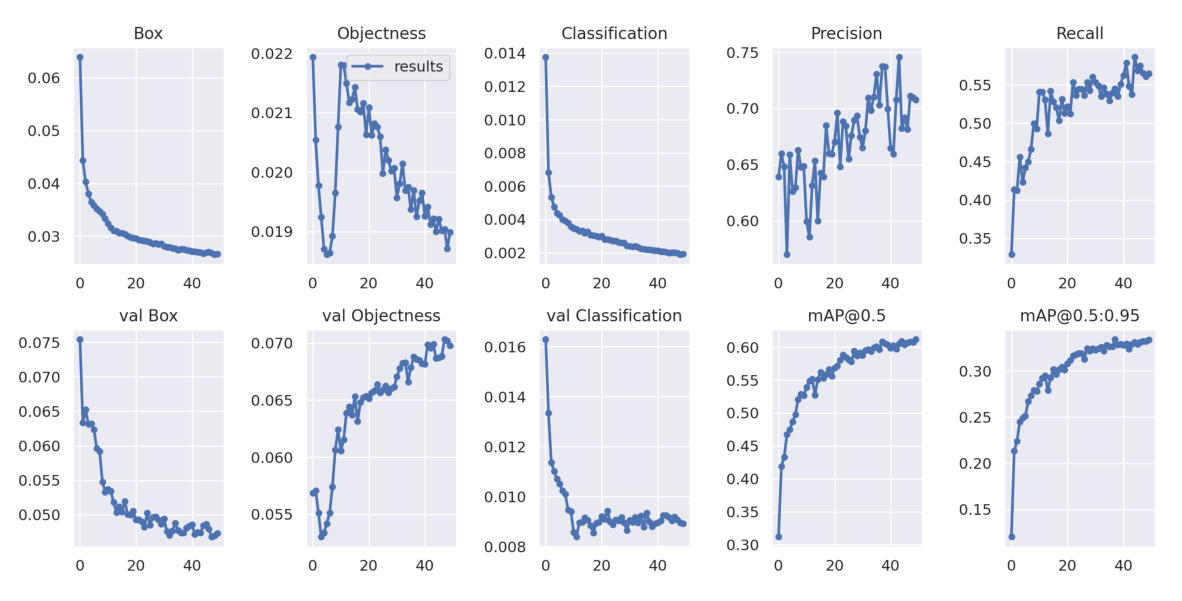


Displaying ResNet training results:


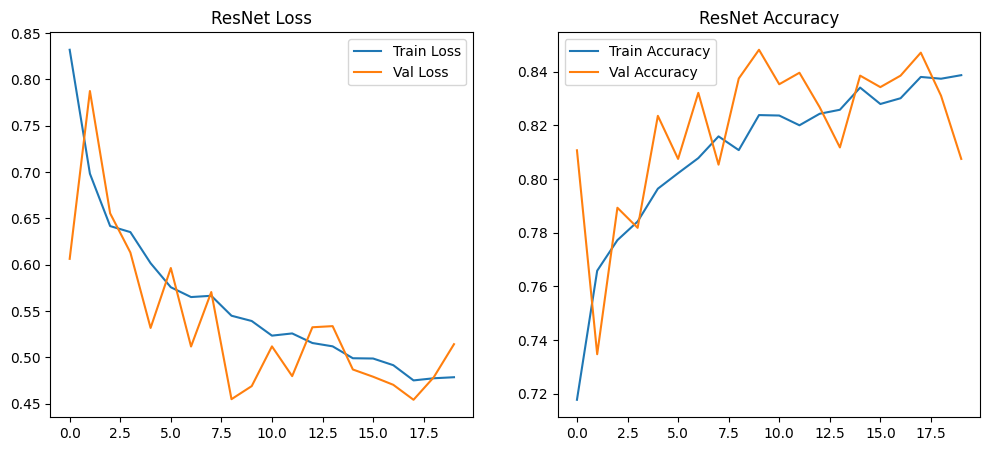


Running prediction on a random test image...
Selected test image: /kaggle/working/prepared_data/scene_classifier_data/test/Night/e89fe478-dc8070fb.jpg
==> ResNet Predicted Scene: Night
Namespace(weights=['/kaggle/working/yolov7/runs/train/yolov7_adverse/weights/best.pt'], source='/kaggle/working/prepared_data/scene_classifier_data/test/Night/e89fe478-dc8070fb.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='/kaggle/working/inference_results', name='test_output', exist_ok=True, no_trace=False)
Traceback (most recent call last):
  File "/kaggle/working/yolov7/detect.py", line 196, in <module>
    detect()
  File "/kaggle/working/yolov7/detect.py", line 34, in detect
    model = attempt_load(weights, map_location=device)  # load FP32 model
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/kaggle/working/yolov7/models/experimen

In [7]:
# --- [PHASE 5] EVALUATION AND PREDICTION ---
print("="*80)
print("--- [PHASE 5] EVALUATION AND PREDICTION ---")
print("="*80)
yolo_results_path = 'yolov7/runs/train/yolov7_adverse/results.png'
if os.path.exists(yolo_results_path):
    print("Displaying YOLOv7 training results:")
    plt.figure(figsize=(15, 10)); plt.imshow(Image.open(yolo_results_path)); plt.axis('off'); plt.show()

print("\nDisplaying ResNet training results:")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss'); plt.title('ResNet Loss'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(history['train_acc'], label='Train Accuracy'); plt.plot(history['val_acc'], label='Val Accuracy'); plt.title('ResNet Accuracy'); plt.legend()
plt.show()

print("\nRunning prediction on a random test image...")
test_image_files = glob.glob(os.path.join(SCENE_TEST_PATH, '*/*.*'))
if not test_image_files:
    print("No images found in the test set for prediction. Using a validation image instead.")
    test_image_files = glob.glob(os.path.join(SCENE_VAL_PATH, '*/*.*'))

if test_image_files:
    test_image_path = random.choice(test_image_files)
    print(f"Selected test image: {test_image_path}")

    model_resnet.eval()
    input_image = Image.open(test_image_path).convert("RGB")
    image_for_resnet = data_transforms['test'](input_image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model_resnet(image_for_resnet)
        _, preds = torch.max(outputs, 1)
        predicted_scene = resnet_class_names[preds[0]]
        print(f"==> ResNet Predicted Scene: {predicted_scene}")

    best_yolo_weights = '/kaggle/working/yolov7/runs/train/yolov7_adverse/weights/best.pt'
    os.chdir('yolov7')
    !python detect.py --weights {best_yolo_weights} --conf 0.25 --img-size 640 --source {test_image_path} --project /kaggle/working/inference_results --name test_output --exist-ok
    os.chdir('/kaggle/working/')

    predicted_image_path = f'/kaggle/working/inference_results/test_output/{os.path.basename(test_image_path)}'
    if os.path.exists(predicted_image_path):
        plt.figure(figsize=(15, 10)); plt.imshow(Image.open(predicted_image_path)); plt.title(f"YOLOv7 Detections on Predicted Scene: {predicted_scene}"); plt.axis('off'); plt.show()
else:
    print("Could not find any test or validation images to run prediction on.")

In [8]:
# --- [PHASE 6] SAVE FINAL MODELS ---
print("\n" + "="*80)
print("--- [PHASE 6] SAVE FINAL MODELS ---")
print("="*80)
resnet_save_path = os.path.join(FINAL_MODELS_PATH, "resnet50_scene_classifier.pth")
torch.save(model_resnet.state_dict(), resnet_save_path)
print(f"ResNet model saved to: {resnet_save_path}")

yolo_save_path = os.path.join(FINAL_MODELS_PATH, "yolov7_object_detector.pt")
best_yolo_weights_source = '/kaggle/working/yolov7/runs/train/yolov7_adverse/weights/best.pt'
if os.path.exists(best_yolo_weights_source):
    shutil.copy(best_yolo_weights_source, yolo_save_path)
    print(f"YOLOv7 model saved to: {yolo_save_path}")
else:
    print("Best YOLOv7 model weights not found, could not save.")
    
print("\n" + "="*80)
print("--- ALL TASKS COMPLETE ---")
print("You can now download the models from the '/kaggle/working/final_trained_models/' directory.")
print("="*80)


--- [PHASE 6] SAVE FINAL MODELS ---
ResNet model saved to: /kaggle/working/final_trained_models/resnet50_scene_classifier.pth
YOLOv7 model saved to: /kaggle/working/final_trained_models/yolov7_object_detector.pt

--- ALL TASKS COMPLETE ---
You can now download the models from the '/kaggle/working/final_trained_models/' directory.
